In [1]:
import pandas as pd 

df_scaled = pd.read_csv('../data/scaled_data.csv')
df_not_scaled = pd.read_csv('../data/not_scaled_data.csv')

In [2]:
df_not_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4735 entries, 0 to 4734
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               4735 non-null   int64  
 1   homeType              4735 non-null   int64  
 2   yearBuilt             4735 non-null   int64  
 3   lotAreaValue          4735 non-null   float64
 4   livingAreaValue       4735 non-null   float64
 5   bedrooms              4735 non-null   int64  
 6   bathrooms             4735 non-null   float64
 7   stories               4735 non-null   float64
 8   hasFireplace          4735 non-null   int64  
 9   taxAssessedValue      4735 non-null   float64
 10  rentZestimate         4735 non-null   float64
 11  price                 4735 non-null   int64  
 12  parkingCapacity       4735 non-null   int64  
 13  hasCooling            4735 non-null   int64  
 14  hasHeating            4735 non-null   int64  
 15  hasFireplace.1       

In [8]:
from sklearn import metrics
import numpy as np

def calc_median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y_pred, y_test):
    r2 = metrics.r2_score(y_test, y_pred)
    smse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mean_ae = metrics.mean_absolute_error(y_test, y_pred)
    mean_ape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    median_ae = metrics.median_absolute_error(y_test, y_pred)
    median_ape = calc_median_absolute_percentage_error(y_test, y_pred)
    return [r2, smse, mean_ae, mean_ape, median_ae, median_ape]
    
def within_x_percent(y_pred, y_test, x):
    return np.sum(np.abs((y_pred - y_test)/y_test) < x) / len(y_test) * 100

def show_metrics(y_pred, y_test, target_scaler = None, logarithm = False):        
    metrics_df = pd.DataFrame(columns=['Target', 'R2', 'Root Mean Squared Error', 'Mean Absolute Error',
                                            'Mean Absolute Percentage Error', 'Median Absolute Error', 'Median Absolute Percentage Error'])
    
    metrics_df.loc[0] = ['Target is scaled'] + calculate_metrics(y_pred, y_test)
    
    if target_scaler:
        y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        metrics_df.loc[1] = ['Scaled Target is inversed to real value'] + calculate_metrics(y_pred, y_test)

    
    if logarithm and target_scaler:
        y_pred = np.power(10, y_pred)
        y_test = np.power(10, y_test)
        metrics_df.loc[2] = ['Target -> 10 ^ Target'] + calculate_metrics(y_pred, y_test)
    
    dist_df = pd.DataFrame({"within 5%": [within_x_percent(y_pred, y_test, 0.05)],
                    "within 10%": [within_x_percent(y_pred, y_test, 0.10)],
                    "within 20%": [within_x_percent(y_pred, y_test, 0.20)],
                    "within 50%": [within_x_percent(y_pred, y_test, 0.50)],
                    "median absolute percentage error": [calc_median_absolute_percentage_error(y_test, y_pred)]}, index=['Percentage'])
        
    display(metrics_df)
    display(dist_df)

In [4]:
from abc import ABC, abstractmethod
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

class RegressionModel(ABC):
    def __init__(self, features, target, params, scale=True, logarithm=False):
        if scale:
            self.feature_scaler = StandardScaler()
            self.target_scaler = StandardScaler()
            self.features = self.feature_scaler.fit_transform(features)
            self.target = self.target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()
        else:
            self.feature_scaler = None
            self.target_scaler = None
            self.features = features
            self.target = target.values.flatten()
            
        self.logarithm = logarithm
        
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.target, test_size=0.2, random_state=42)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        self.model = self.create_model(params)
        self.search_params = self.set_search_params()
        self.model.fit(X_train, y_train)
        self.y_pred = self.model.predict(X_test)
        
    @abstractmethod
    def create_model(self, params):
        pass
    
    @abstractmethod
    def set_search_params(self):
        pass
    
    def predict(self, features):
        if self.feature_scaler:
           features = self.feature_scaler.transform(features)
        return self.model.predict(features)
    
    def grid_search(self):
        grid_search = GridSearchCV(self.model, self.search_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(self.X_train, self.y_train)
        best_model = grid_search.best_estimator_
        test_score = best_model.score(self.X_test, self.y_test)
        self.model = best_model
        self.y_pred = self.model.predict(self.X_test)
        return best_model, test_score
    
    def show_metrics(self):
        show_metrics(self.y_pred, self.y_test, self.target_scaler, self.logarithm)
    
    def draw_predictions(self, log=False):
        if self.target_scaler:
            y_pred = self.target_scaler.inverse_transform(self.y_pred.reshape(-1, 1)).ravel()
            y_test = self.target_scaler.inverse_transform(self.y_test.reshape(-1, 1)).ravel()
        else:
            y_pred = self.y_pred
            y_test = self.y_test
        
        if log:
            y_pred = np.power(10, y_pred)
            y_test = np.power(10, y_test)
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Predicted vs Actual')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
        plt.title('Actual vs Predicted Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.show()

In [5]:
from sklearn.svm import SVR
class SVRModel(RegressionModel):
    def create_model(self, params):
        return SVR(**params)
    def set_search_params(self):
        return {
            'C': [0.1, 1, 10, 100, 1000],
            'epsilon': [0.01, 0.1, 0.2, 0.5, 1],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        }

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target is scaled,0.871079,0.366668,0.265162,1.404107,0.185315,31.375882
1,Scaled Target is inversed to real value,0.871079,0.100343,0.072565,0.011972,0.050713,0.849034
2,Target -> 10 ^ Target,0.843808,499246.380105,254232.313668,0.171380,120122.155287,11.659583


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,22.80887,43.611404,69.06019,95.670539,11.659583


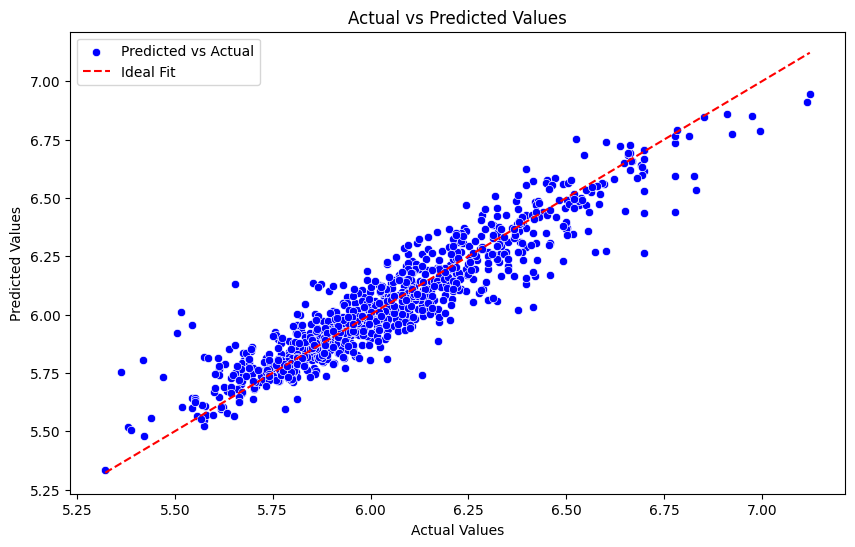

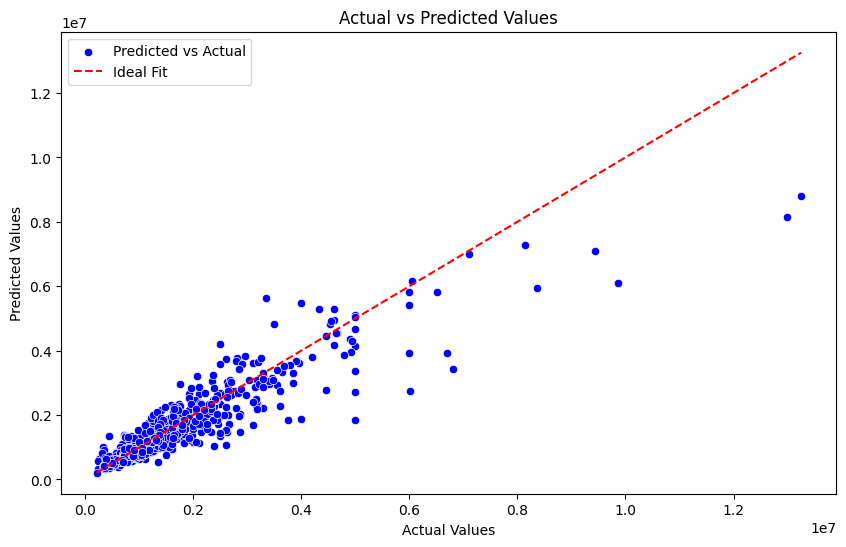

In [9]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
target = df_not_scaled['log_price']
model = SVRModel(features, target, params={'C': 10, 'epsilon': 0.05, 'kernel': 'rbf'}, scale=True, logarithm=True)
model.show_metrics()
model.draw_predictions()
model.draw_predictions(log=True)

In [75]:
model.grid_search()

KeyboardInterrupt: 

In [103]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
target = df_not_scaled['price']
model = SVRModel(features, target, params={'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}, scale=True, logarithm=False)
model.show_metrics()
model.draw_predictions()

In [91]:
model.grid_search()

GridSearchCV(cv=5, estimator=SVR(C=1000, epsilon=0.01), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'epsilon': [0.01, 0.1, 0.2, 0.5, 1],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_absolute_error')


(SVR(C=1000, epsilon=0.01, gamma='auto'), 0.0019784610496236255)

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target is scaled,0.862291,0.330364,0.170814,0.970796,0.100964,25.506791
1,Scaled Target is inversed to real value,0.862291,468778.111756,242381.071283,0.181232,143265.879004,13.262752


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,20.380148,40.232313,67.370644,94.931362,13.262752


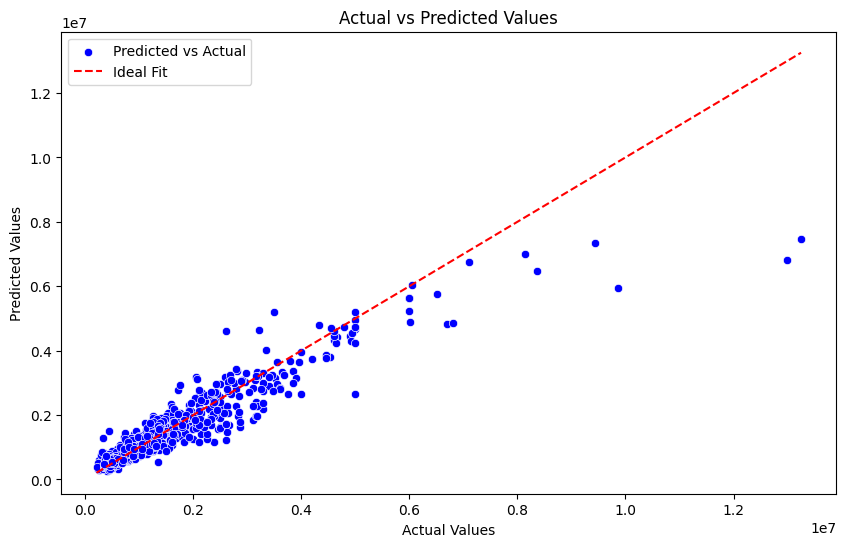

In [10]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue', 'zipcode'])
target = df_not_scaled['price']
model = SVRModel(features, target, params={'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}, scale=True, logarithm=False)
model.show_metrics()
model.draw_predictions()

In [ ]:
model.grid_search()

In [84]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(RegressionModel):
    def create_model(self, params):
        return LinearRegression()
    def set_search_params(self):
        return {}
    

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target,0.798541,0.125435,0.096281,0.015948,0.077662,1.296173
1,Target -> 10 ^ Target,0.806995,554970.979274,312059.681803,0.227296,183111.961857,17.214551


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,14.255544,29.250264,54.804646,92.291447,17.214551


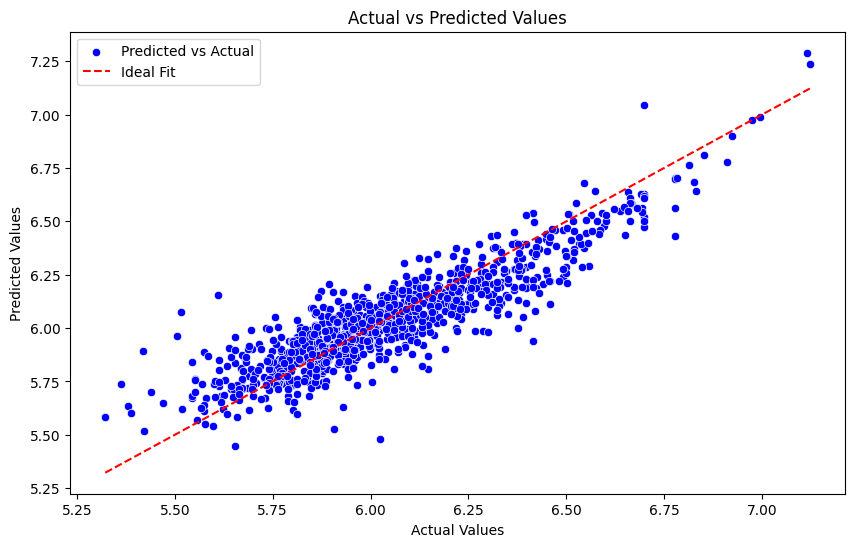

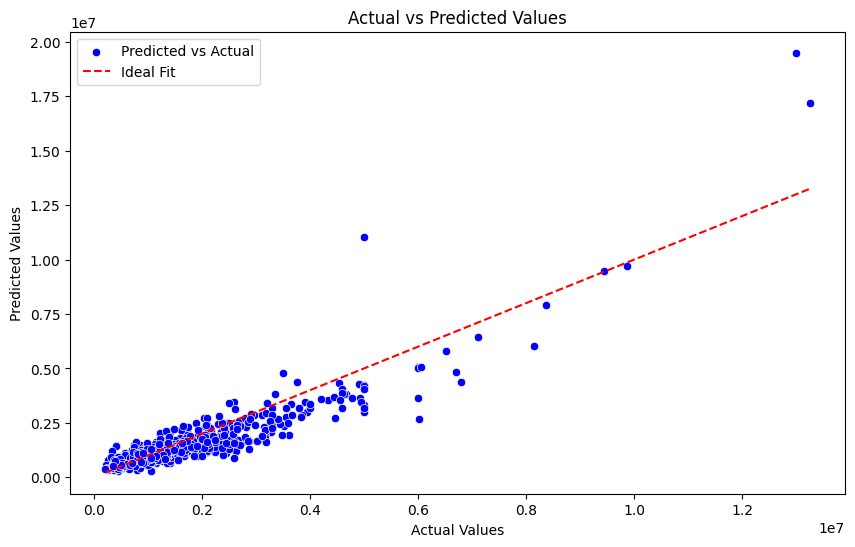

In [86]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
target = df_not_scaled['log_price']
model = LinearRegressionModel(features, target, params={}, scale=True, logarithm=True)
model.show_metrics()
model.draw_predictions()
model.draw_predictions(log=True)

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target,0.909844,379300.396771,251625.982397,0.207983,157733.756855,14.416989


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,17.212249,35.586061,63.041183,92.713833,14.416989


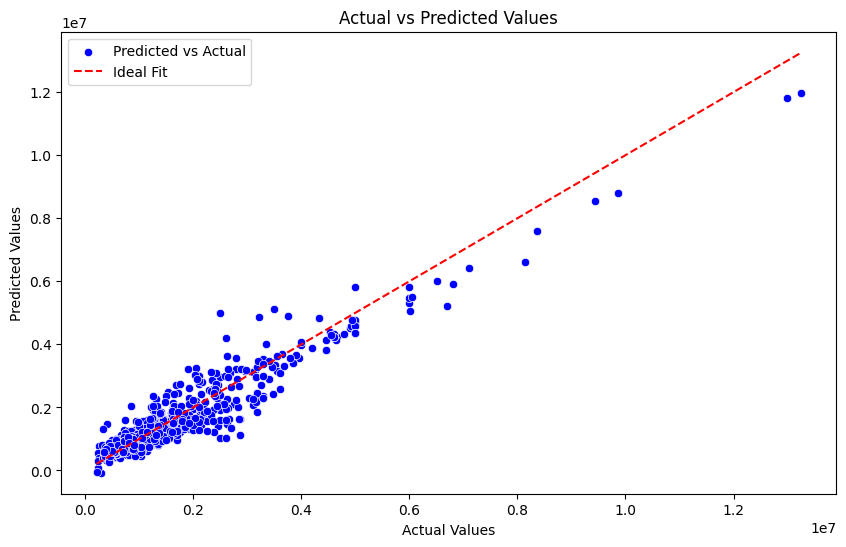

In [88]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
target = df_not_scaled['price']
model = LinearRegressionModel(features, target, params={}, scale=True, logarithm=False)
model.show_metrics()
model.draw_predictions()

In [102]:
from sklearn.neighbors import KNeighborsRegressor

class KNeighborsRegressorModel(RegressionModel):
    def create_model(self, params):
        return KNeighborsRegressor(**params)
    def set_search_params(self):
        return {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Scaled Target,0.855366,0.338568,0.211086,1.302885,0.118398,29.084042
1,Not Scaled Target,0.855366,480420.216232,299525.690069,0.232616,168004.486810,16.095012


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,16.895459,34.213305,57.972545,91.55227,16.095012


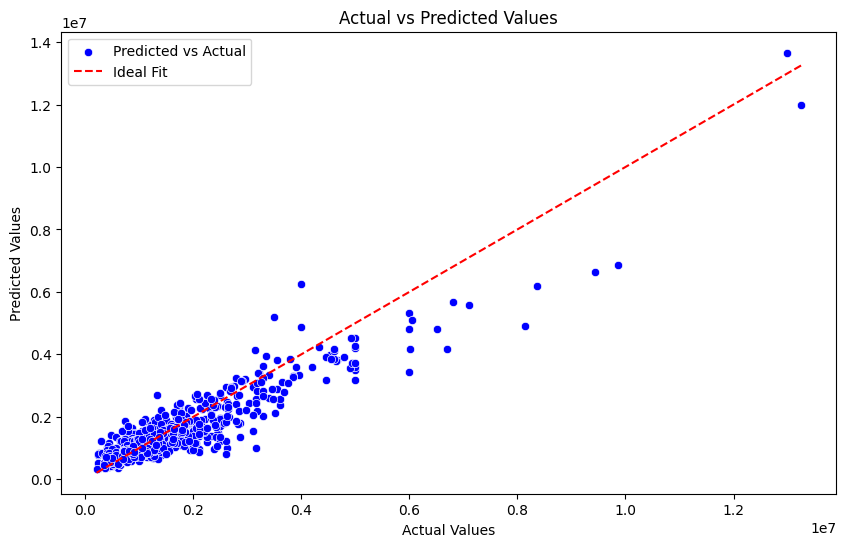

In [103]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
target = df_not_scaled['price']
model = KNeighborsRegressorModel(features, target, params={'n_neighbors': 7, 'weights': 'distance'}, scale=True, logarithm=False)
model.draw_predictions()

In [182]:
model.grid_search()

(KNeighborsRegressor(n_neighbors=7, weights='distance'), 0.8553657203636134)

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Scaled Target,0.788849,0.469254,0.346282,1.844683,0.254382,39.627742
1,Not Scaled Target,0.788849,0.128417,0.094764,0.015664,0.069614,1.154989
2,Target -> 10 ^ Target,0.834366,514114.874812,304338.053255,0.219858,164855.712589,15.854591


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,17.845829,33.896515,58.289335,91.763464,15.854591


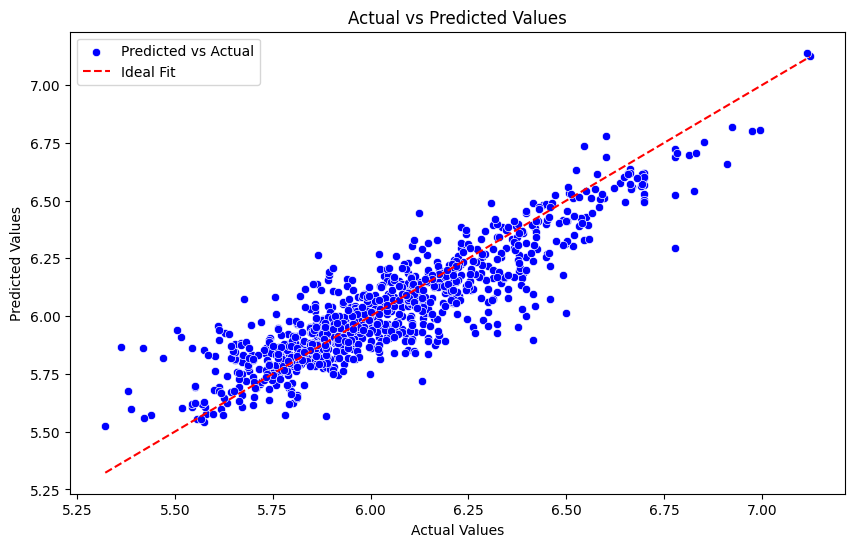

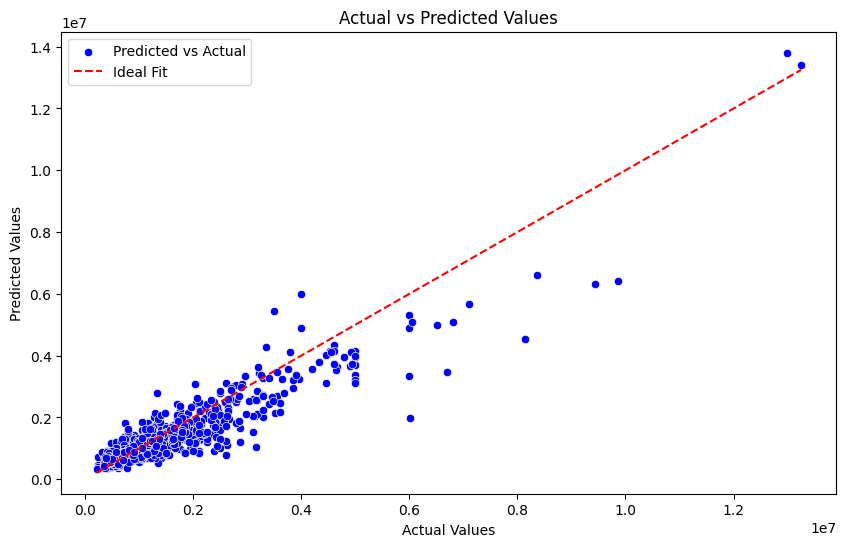

In [104]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
target = df_not_scaled['log_price']
model = KNeighborsRegressorModel(features, target, params={'n_neighbors': 5, 'weights': 'distance'}, scale=True, logarithm=True)
model.draw_predictions()
model.draw_predictions(log=True)

In [105]:
from sklearn.tree import DecisionTreeRegressor

class DecisionTreeRegressorModel(RegressionModel):
    def create_model(self, params):
        return DecisionTreeRegressor(**params)
    def set_search_params(self):
        return {
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 4, 8],
        }

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Scaled Target,0.693064,0.493213,0.203355,1.094718,0.105892,24.624586
1,Not Scaled Target,0.693064,699857.068282,288556.419091,0.211143,150257.681416,14.263997


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,16.050686,35.797254,62.935586,93.664203,14.263997


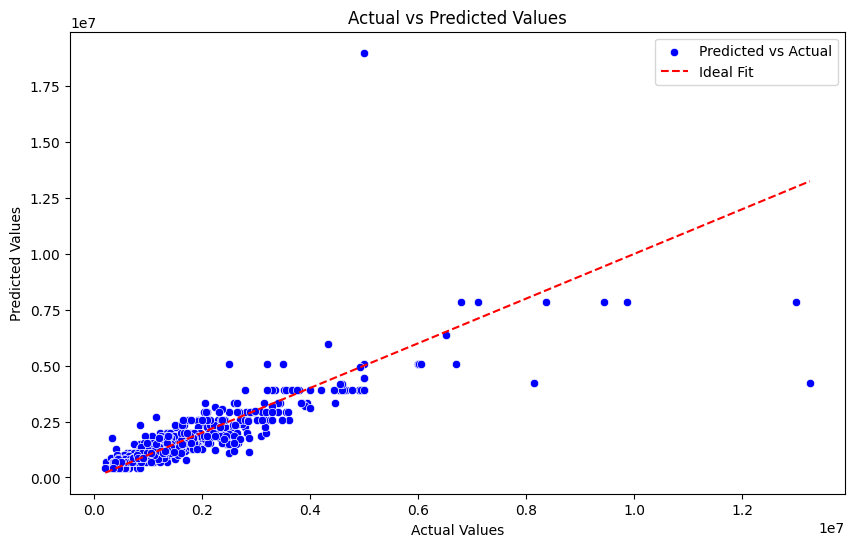

In [106]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
target = df_not_scaled['price']
model = DecisionTreeRegressorModel(features, target, params={'max_depth': 7, 'min_samples_split': 4}, scale=True, logarithm=False)
model.draw_predictions()


In [187]:
model.grid_search()

(DecisionTreeRegressor(max_depth=7, min_samples_split=4), 0.6933435834222461)

In [55]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
target = df_not_scaled['log_price']
model = DecisionTreeRegressorModel(features, target, params={'max_depth': 7, 'min_samples_split': 4}, scale=True, logarithm=True)
model.draw_predictions()
model.draw_predictions(log=True)

NameError: name 'DecisionTreeRegressorModel' is not defined